This script performs the following:

1. Permutation Test (Primary analysis)
--------------------------------------
- For each gene, predicted transcription rates were permuted 1000 times.
- Correlations between permuted predicted rates and gene expression were calculated.
- Observed correlations were then compared against this null.

2. Q-Q Plot (Optional / exploratory analysis)
---------------------------------------------
-  Observed vs Permuted Null (Pooled)
- Not very interpretable (at least to me)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sp
import warnings
from scipy.stats import ks_2samp, anderson_ksamp
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import re
import seaborn as sns

In [2]:
predicted_rates_df = pd.read_csv('predicted_rates_sig_associations.tsv', sep = '\t', index_col = 0)
filtered_deg_df  = pd.read_csv('deseqoutput_protein-ids.tsv', sep = '\t', index_col = 0).T

In [3]:
int_genes = set(['-'.join(g.split('-')[:-1]) for g in predicted_rates_df.columns])
int_deg = filtered_deg_df.loc[:, filtered_deg_df.columns.isin(int_genes)]
int_deg.head(3)

gene-id,cds-NP_414578.2,cds-NP_414677.1,cds-NP_414683.1,cds-NP_414706.2,cds-NP_414752.1,cds-NP_414760.1,cds-NP_414761.1,cds-NP_414767.1,cds-NP_414768.1,cds-NP_414776.1,...,cds-NP_418723.1,cds-NP_418724.1,cds-NP_418725.4,cds-NP_418726.1,cds-NP_418727.1,cds-NP_418733.1,cds-NP_418734.1,cds-NP_418735.2,cds-NP_418736.3,cds-NP_418740.1
NT12189,0.362177,1.230408,-1.030290,0.672323,-0.443725,0.776436,1.298233,0.539357,0.071231,1.368819,...,-6.801205,-5.341317,-5.301443,-4.398850,-4.910014,-6.313384,-8.486121,-8.306573,-8.132702,-6.892865
NT12177,2.176615,-7.427777,-1.003958,0.574438,-1.212497,-4.803334,-5.242669,-0.210362,0.313198,1.467764,...,-6.585919,-7.214152,-6.349599,-6.745688,-5.606532,1.165615,-6.033914,-2.345652,-2.845027,-0.440900
NT12130,1.569678,-6.937423,1.079472,1.579887,0.269665,-1.889564,-1.424491,0.958389,1.154479,0.753323,...,-8.309324,-6.881677,-5.802867,-6.548193,-6.518633,1.688403,-2.777924,-1.683232,-1.386437,0.036088


In [4]:
def standardize_gene_names(gene_name):
    return re.sub(r"-\d+$", "", gene_name)

# Standardize column names in predicted_rates_df
predicted_rates_df.columns = [standardize_gene_names(col) for col in predicted_rates_df.columns]

# Align strains in both datasets
common_strains = predicted_rates_df.index.intersection(filtered_deg_df.index)
predicted_rates_df = predicted_rates_df.loc[common_strains]
filtered_deg_df = filtered_deg_df.loc[common_strains]

# Aggregate predicted values by mean for duplicate gene names
predicted_rates_df = predicted_rates_df.groupby(predicted_rates_df.columns, axis=1).mean()
common_genes = predicted_rates_df.columns.intersection(filtered_deg_df.columns)

# Compute observed correlations
pearson = {}
observed_corrs = []
all_permuted_corrs = []

res = []

for gene in common_genes:
    df_merged = pd.merge(
        predicted_rates_df[[gene]], filtered_deg_df[[gene]],
        left_index=True, right_index=True, how='inner'
    ).dropna()
    
    df_merged.columns = ['Predicted transcription rate', 'log2foldchange'] 
    if df_merged['Predicted transcription rate'].nunique() == 1 or df_merged['log2foldchange'].nunique() == 1:
        continue  # Skip if constant values

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        p, _ = sp.pearsonr(df_merged['Predicted transcription rate'], df_merged['log2foldchange'])

    #pearson[gene] = round(p, 2)
    pearson[gene] = p
    observed_corrs.append(p)
    res.append([0, p])

# Permutation test function
def permutation_test(actual, predicted, n_permutations=1000):
    mask = np.isfinite(actual) & np.isfinite(predicted)
    actual = actual[mask]
    predicted = predicted[mask]
    
    observed_corr, _ = sp.pearsonr(actual, predicted)
    
    permuted_corrs = np.array([
        sp.pearsonr(actual, np.random.permutation(predicted))[0]
        for _ in range(n_permutations)
    ])
    
    return observed_corr, permuted_corrs

# Compute permutation correlations and p-values for each gene
gene_p_values = {}

for gene in common_genes:
    if gene not in pearson:
        continue
    observed_corr, permuted_corrs = permutation_test(
        filtered_deg_df[gene], predicted_rates_df[gene]
    )
    all_permuted_corrs.extend(permuted_corrs)

    for i, p in enumerate(permuted_corrs):
        res.append([i+1, p])
    
    # Compute empirical p-value for this gene
    p_value = np.mean(permuted_corrs >= observed_corr)
    gene_p_values[gene] = p_value

df = pd.DataFrame(res,
                  columns=['iteration', 'corr'])

# KS-test between observed and permuted correlation distributions
ks_stat, ks_p_value = ks_2samp(observed_corrs, all_permuted_corrs)

# Anderson-Darling test between observed and permuted distributions
ad_stat, ad_critical, ad_significance = anderson_ksamp([observed_corrs, all_permuted_corrs])

# Print KS-test results
print(f"\n=== Kolmogorov-Smirnov (KS) Test ===")
print(f"KS Test Statistic: {ks_stat:.4f}")
print(f"KS Test p-value: {ks_p_value:.4f}")

if ks_p_value < 0.05:
    print("The observed and null distributions are significantly different (p < 0.05).")
else:
    print("The observed and null distributions are NOT significantly different (p > 0.05).")

# Print AD-test results
print("\n=== Anderson-Darling (AD) Test ===")
print(f"AD Test Statistic: {ad_stat:.4f}")
print(f"Significance Level (p-value equivalent): {ad_significance:.4f}")

if ad_significance < 0.05:
    print("The observed and null distributions are significantly different (p < 0.05).")
else:
    print("The observed and null distributions are NOT significantly different (p > 0.05).")


# Print summary of permutation test results
significant_genes = {gene: p for gene, p in gene_p_values.items() if p < 0.05}
print(f"\n=== Permutation Test Results ===")
print(f"Number of significant genes (p < 0.05): {len(significant_genes)} / {len(gene_p_values)}")
print(f"Example significant genes: {list(significant_genes.keys())[:5]} (showing up to 5)")



=== Kolmogorov-Smirnov (KS) Test ===
KS Test Statistic: 0.1565
KS Test p-value: 0.0000
The observed and null distributions are significantly different (p < 0.05).

=== Anderson-Darling (AD) Test ===
AD Test Statistic: 54.0650
Significance Level (p-value equivalent): 0.0010
The observed and null distributions are significantly different (p < 0.05).

=== Permutation Test Results ===
Number of significant genes (p < 0.05): 51 / 254
Example significant genes: ['cds-NP_414683.1', 'cds-NP_414752.1', 'cds-NP_414784.1', 'cds-NP_414847.3', 'cds-NP_414858.1'] (showing up to 5)


/var/folders/ys/t0s5987940jf4x94c3v464w00000gn/T/ipykernel_18191/1270086511.py:82: UserWarning: p-value floored: true value smaller than 0.001
  ad_stat, ad_critical, ad_significance = anderson_ksamp([observed_corrs, all_permuted_corrs])


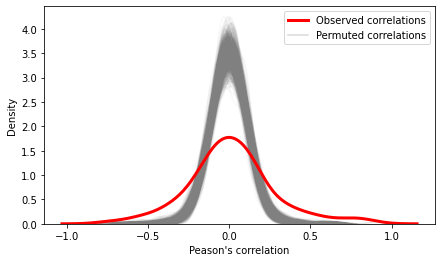

In [5]:
plt.figure(figsize=(7, 4))

sns.kdeplot(data=df[df['iteration'] == 0],
            x='corr',
            color='r',
            lw=3,
            label='Observed correlations')
sns.kdeplot(data=df[df['iteration'] == 1],
            x='corr',
            color='grey',
            # lw=0.5,
            alpha=0.3,
            rasterized=True,
            label='Permuted correlations',
            zorder=-1)
for i in range(2, 1001):
    sns.kdeplot(data=df[df['iteration'] == i],
                x='corr',
                color='grey',
                # lw=0.5,
                alpha=0.05,
                rasterized=True,
                zorder=-1)

plt.legend()
plt.xlabel("Peason's correlation")

sns.despine(top=False, right=False)

plt.savefig('corr_distribution.svg', dpi=300)

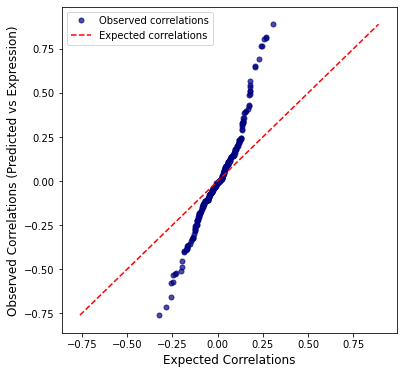

In [8]:
observed_corrs_array = np.array(list(pearson.values()))  # Observed correlations
null_corrs_permuted = np.array(all_permuted_corrs)      # Permuted correlations (global pooled)

# Sort for Q-Q plot
observed_sorted = np.sort(observed_corrs_array)
null_sorted = np.sort(null_corrs_permuted)

min_len = min(len(observed_sorted), len(null_sorted))
observed_sorted = np.sort(np.random.choice(observed_sorted, min_len, replace=False))
null_sorted = np.sort(np.random.choice(null_sorted, min_len, replace=False))

# Generate Q-Q plot
plt.figure(figsize=(6, 6))
plt.plot(null_sorted, observed_sorted, 'o', color='navy', alpha=0.7, markersize=5, label='Observed correlations')
plt.plot([min(null_sorted.min(), observed_sorted.min()),
          max(null_sorted.max(), observed_sorted.max())],
         [min(null_sorted.min(), observed_sorted.min()),
          max(null_sorted.max(), observed_sorted.max())],
         'r--', label='Expected correlations')

plt.xlim(min(null_sorted.min(), observed_sorted.min()) - 0.1, max(null_sorted.max(), observed_sorted.max()) + 0.1)
plt.ylim(min(null_sorted.min(), observed_sorted.min()) - 0.1, max(null_sorted.max(), observed_sorted.max()) + 0.1)

plt.xlabel('Expected Correlations', fontsize=12)
plt.ylabel('Observed Correlations (Predicted vs Expression)', fontsize=12)
plt.legend()
plt.savefig('qq_plot.svg', dpi=300)